In [1]:
import parcels
import pooch
import xarray
import cartopy


print(f"{parcels.__version__=}")
print(f"{xarray.__version__=}")
print(f"{cartopy.__version__=}")

parcels.__version__='3.0.0'
xarray.__version__='2023.12.0'
cartopy.__version__='0.22.0'


In [2]:
import pooch
import xarray as xr


url = "https://github.com/LaPoGeoMar/Proj_Modelagem_Pellet/releases/download"
version = "v0.1.0"

fname = pooch.retrieve(
    url=f"{url}/{version}/model_tides_and_winds.nc",
    known_hash="sha256:1b01945c529e9f0489a659fc8360344ff58925544a2f7e543148d4f31c6dd0e8",
)

ds = xr.open_dataset(fname)
ds

<xarray.Dataset>
Dimensions:     (time: 8772, m: 138, n: 218)
Coordinates:
    Layer       float32 ...
    latitude    (m, n) float32 ...
    longitude   (m, n) float32 ...
  * m           (m) float32 -48.87 -48.87 -48.86 -48.85 ... -47.53 -47.52 -47.51
  * n           (n) float32 -28.62 -28.62 -28.61 -28.6 ... -26.48 -26.47 -26.47
  * time        (time) datetime64[ns] 2021-01-01 ... 2022-01-01
Data variables:
    waterlevel  (time, m, n) float32 ...
    velocity_x  (time, m, n) float32 ...
    velocity_y  (time, m, n) float32 ...
Attributes: (12/25)
    title:                         NetCDF created from NEFIS-file trim-sc_fl_...
    institution:                   
    source:                        Delft3D trim file
    history:                       Mon Aug 22 14:21:18 2022: ncks -4 -L 1 jan...
    references:                    http://svn.oss.deltares.nl
    email:                         
    ...                            ...
    geospatial_lon_units:          dergees_east
    geospatial_vertical_min:       2.2039968967437744
    geospatial_vertical_max:       547.0967407226562
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  down
    NCO:                           netCDF Operators version 5.1.0 (Homepage =...

In [3]:
# https://github.com/OceanParcels/parcels/issues/1358
    
ds = ds.isel(
    m=slice(1, -1),
    n=slice(1, -1),
)

## Parcels expect the arrays to be in time, lat, lon order.

In [4]:
ds = ds.transpose("time", "n", "m")

In [5]:
from parcels import FieldSet


variables = {
    "U": "velocity_x", 
    "V": "velocity_y",
}

dimensions = {
    "U": {
        "time": "time",
        "lat": "n", #"latitude",
        "lon": "m", #"longitude",
    },
    "V": {
        "time": "time",
        "lat": "n", #"latitude",
        "lon": "m", #"longitude",
    },
}

fieldset = FieldSet.from_xarray_dataset(ds, variables, dimensions)

In [6]:
import numpy as np


# https://github.com/OceanParcels/parcels/issues/1235 ?
x, y = -48.6, -26.89  # Itajaí
# x, y = -48.66, -27  # Sim 1
# x, y = -48.66, -27.1  # Sim 2
# x, y = -48.66, -27.3  # Sim 3
# x, y = -48.66, -27.4  # Sim 4
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

xi = find_nearest(ds["m"], x)
yi = find_nearest(ds["n"], y)

x = ds["m"][xi]
y = ds["n"][yi]

# x = ds["m"][xi:xi+100].to_numpy()[()]
# y = [ds["n"][yi].to_numpy()[()]] * len(x)

/tmp/ipykernel_29710/1528932092.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  ax.plot(X, Y, "k.", alpha=0.25, zorder=0, color="lightgrey");


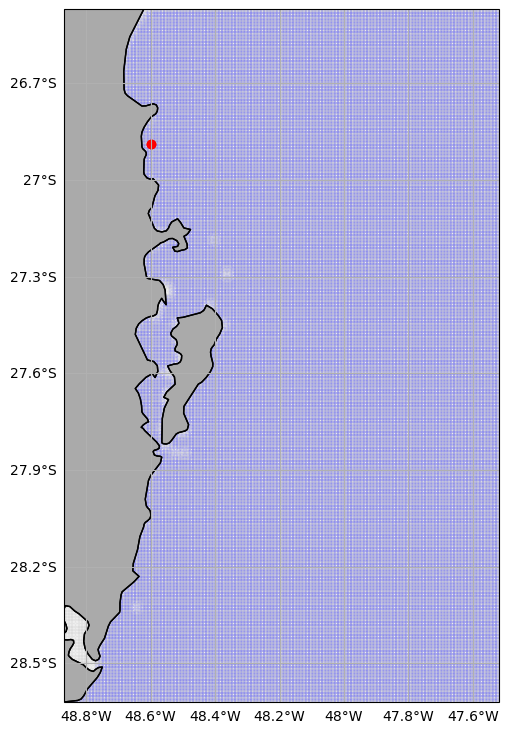

In [7]:
# %matplotlib notebook

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER


# Coastline
feature = NaturalEarthFeature(
    name="coastline",
    category="physical",
    scale="10m",
    edgecolor="#000000",
    facecolor="#AAAAAA",
)

bbox = (
    ds["longitude"].min().to_numpy()[()],
    ds["longitude"].max().to_numpy()[()],
    ds["latitude"].min().to_numpy()[()],
    ds["latitude"].max().to_numpy()[()],
)

def creat_map(projection=ccrs.PlateCarree(), figsize=(9, 9)):
    fig, ax = plt.subplots(
        figsize=figsize,
        subplot_kw={
            "projection": projection,
        },
    )
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.coastlines(resolution="10m")
    return fig, ax


# Figure
fig, ax = creat_map(projection=ccrs.PlateCarree(), figsize=(9, 9))
ax.plot(x, y, "ro", zorder=2)
ax.add_feature(feature, zorder=0)
ax.set_extent(bbox)

ax.plot(ds["longitude"], ds["latitude"], color="blue", marker="o", markerfacecolor="none", alpha=0.15, zorder=0);
X, Y = np.meshgrid(ds["m"], ds["n"])
ax.add_feature(feature, zorder=1)
ax.plot(x, y, "ro")  # Itajaí
ax.plot(X, Y, "k.", alpha=0.25, zorder=0, color="lightgrey");

In [8]:
from datetime import timedelta
from parcels import ParticleSet, JITParticle, Variable
from operator import attrgetter


# Número de dias que a partícula tem que ficar parada para ser cosiderada "beached."
vicinity = 1

# https://github.com/VictorOnink/Modeling-Global-Plastic-Beaching/blob/main/generalBeachingScenarios.py
class CoastalProximityParticle(JITParticle):
    # First we keep track of how long a particle has been close to the shore.
    prox = Variable("prox", dtype=np.int32, initial=attrgetter("prox"))
    # And we need to define the cutoff point for how long the particle can 
    # be close to shore.
    vic = Variable("vic", dtype=np.float32, initial=vicinity, to_write=False)
    # Now the beaching variables
    # 0=open ocean, 1=beached
    beach = Variable("beach", dtype=np.int32, initial=attrgetter("beach"))
    # Finally, I want to keep track of the age of the particle.
    age = Variable("age",dtype=np.int32,initial=attrgetter("age"))
    # Weight of the particle in tons.
    weights = Variable("weights",dtype=np.float32,initial=attrgetter("weights"))
    # Distance of the particle to the coast.
    distance= Variable("distance", dtype=np.float32, initial=0)


npart = 100 # nº de particulas liberadas
lon = [x] * npart # lon de liberacao das particulas
lat = [y] * npart # lat da liberacao das particulas
repeatdt = timedelta(hours=24)

pset = ParticleSet(
    fieldset=fieldset,
    pclass=CoastalProximityParticle,
    lon=lon,
    lat=lat,
    repeatdt=repeatdt,
)


domain = {
    "N": ds["latitude"].max().to_numpy()[()],
    "S": ds["latitude"].min().to_numpy()[()],
    "E": ds["longitude"].max().to_numpy()[()],
    "W": ds["longitude"].min().to_numpy()[()],
}

In [9]:
from parcels import AdvectionRK4
from parcels import StatusCode


# https://github.com/euroargodev/VirtualFleet/blob/4e524f24e15c5dfc6b8b4f57836953b2ccc9eafe/virtualargofleet/virtualargofleet.py
def KeepInDomain(particle, fieldset, time):
    # out of geographical area : here we can delete the particle
    if particle.state == StatusCode.ErrorOutOfBounds:
        particle.delete()
    
output_file = pset.ParticleFile(
    name="results-model_tides_and_winds.zarr",
    outputdt=timedelta(hours=12)
)

kernels = pset.Kernel(AdvectionRK4) + pset.Kernel(KeepInDomain)

pset.execute(
    kernels,
    runtime=timedelta(days=30),
    dt=timedelta(hours=3),
    output_file=output_file,
)

INFO: Output files are stored in results-model_tides_and_winds.zarr.
  0%|                                                                                                                                                            | 0/2592000.0 [00:00<?, ?it/s]WARNING: ParticleFile chunks are set to (100, 1), but this may lead to a significant slowdown in Parcels when many calls to repeatdt. Consider setting a larger chunk size for your ParticleFile (e.g. chunks=(int(1e4), 1)).
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2592000.0/2592000.0 [00:48<00:00, 53062.10it/s]


In [10]:
from pathlib import Path

def normalize_speed(u, v):
    u_norm = u / np.sqrt(u**2.0 + v**2.0)
    v_norm = v / np.sqrt(u**2.0 + v**2.0)
    speed = (u**2 + v**2) ** 0.5
    return (u_norm, v_norm, speed)


fname = Path("avg-model_tides_and_winds.nc")
if not fname.exists():
    avg = ds.mean(dim="time")
    avg.to_netcdf(fname)
else:
    avg = xr.load_dataset(fname)

u = avg["velocity_x"].squeeze()
v = avg["velocity_y"].squeeze()
u_norm, v_norm, speed = normalize_speed(u, v)

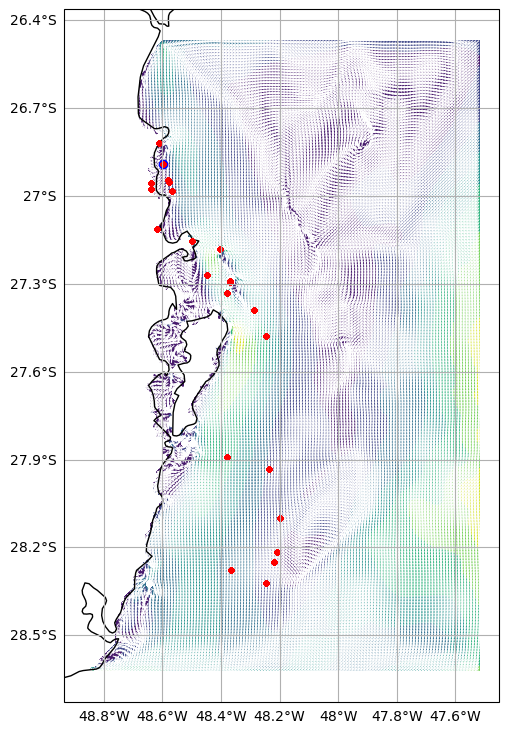

In [11]:
fig, ax = creat_map()
ax.contourf(avg["longitude"], avg["latitude"], speed)
ax.quiver(
    avg["longitude"],
    avg["latitude"],
    u_norm,
    v_norm,
    color="white",
    scale=50,
)

ax.plot(x, y, "bo", label="Itajaí")

for p in pset:
    ax.plot(p.lon, p.lat, "r.")